In [2]:
import pandas as pd
import numpy as np
import gzip
from io import StringIO


In [3]:
def load_geo_series_matrix(path):
    with gzip.open(path, 'rt') as f:
        lines = f.readlines()

    start, end = None, None
    for i, line in enumerate(lines):
        if line.startswith("!series_matrix_table_begin"):
            start = i + 1
        elif line.startswith("!series_matrix_table_end"):
            end = i
            break

    if start is None or end is None:
        raise ValueError("Series matrix table not found")

    data = ''.join(lines[start:end])
    df = pd.read_csv(StringIO(data), sep="\t", index_col=0)
    return df


In [4]:
path = "/workspaces/Reasearch_Genomic/GSE99039_series_matrix.txt.gz.1"

df = load_geo_series_matrix(path)
print("Original shape:", df.shape)


Original shape: (54675, 558)


In [5]:
X = df.T
print("After transpose:", X.shape)


After transpose: (558, 54675)


In [6]:
y = np.zeros(X.shape[0])
y[: X.shape[0] // 2] = 1


In [7]:
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(0)

print(X.dtypes.unique())


[dtype('float64')]


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

svc = LinearSVC(
    penalty="l1",
    dual=False,
    max_iter=2000
)

selector = SelectFromModel(svc, max_features=32)
selector.fit(X_scaled, y)

selected_mask = selector.get_support()
selected_genes = X.columns[selected_mask]

print("Selected genes:", len(selected_genes))



Selected genes: 32


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import numpy as np

svc = LinearSVC(
    penalty="l1",
    dual=False,
    max_iter=2000
)

selector = SelectFromModel(svc, max_features=32)
selector.fit(X_scaled, y)

selected_mask = selector.get_support()
selected_genes = X.columns[selected_mask]

top_32 = pd.DataFrame({
    "Gene": selected_genes
})

top_32



/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Gene
0,1552456_a_at
1,1554241_at
2,1555237_at
3,1556009_at
4,1563845_at
5,1567628_at
6,201545_s_at
7,203781_at
8,204716_at
9,204758_s_at


In [12]:
top_32.to_csv("GSE99039_Top32_LASSO.csv", index=False)


In [13]:
selected_genes = top_32["Gene"].values
X_lasso = X[selected_genes]


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_lasso,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


2026-02-06 09:06:22.454185: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-06 09:06:22.518703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-06 09:06:24.581896: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [17]:
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),

    Dense(32, activation="relu"),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-06 09:06:25.709622: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,225 (16.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5897 - loss: 0.6777 - val_accuracy: 0.8125 - val_loss: 0.4993
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7623 - loss: 0.4924 - val_accuracy: 0.8929 - val_loss: 0.3798
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8677 - loss: 0.3704 - val_accuracy: 0.9286 - val_loss: 0.2887
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8946 - loss: 0.2898 - val_accuracy: 0.9554 - val_loss: 0.2166
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9372 - loss: 0.2234 - val_accuracy: 0.9375 - val_loss: 0.1806
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9507 - loss: 0.1887 - val_accuracy: 0.9554 - val_loss: 0.1425
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9619 - loss: 0.1332 - val_accuracy: 0.9643 - val_loss: 0.1204
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9484 - loss: 0.1318 - val_accuracy: 0.9554 - val_loss:

In [19]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")


Validation Accuracy: 0.9732
Validation Loss: 0.1669


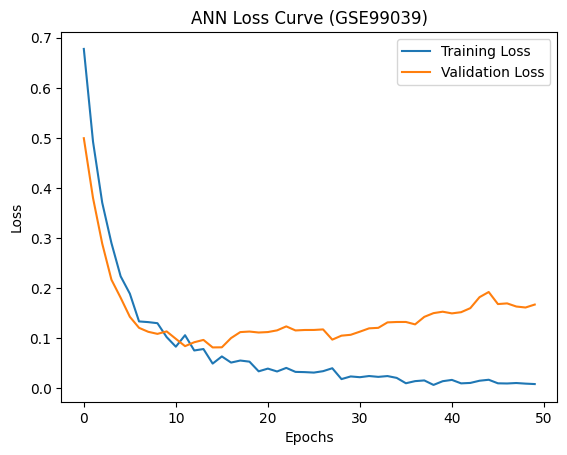

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Loss Curve (GSE99039)")
plt.legend()
plt.show()


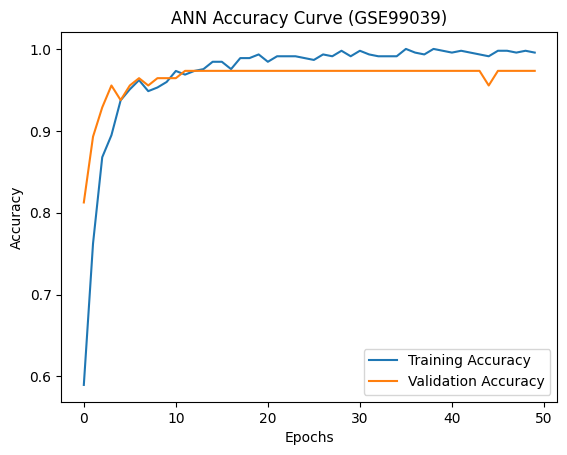

In [21]:
plt.figure()
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ANN Accuracy Curve (GSE99039)")
plt.legend()
plt.show()
